# Maîtriser les expressions régulières

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/04b_regex_TP.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/04b_regex_TP.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/04b_regex_TP.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABmanipulation%2004b_regex_TP%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=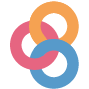" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/04b_regex_TP.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/manipulation/04b_regex_TP.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

# Introduction

`Python` offre énormément de fonctionalités très pratiques pour la manipulation de données
textuelles. C’est l’une des raisons de son
succès dans la communauté du traitement automatisé du langage (NLP, voir partie dédiée).

Dans les chapitres précédents, nous avons parfois été amenés à chercher des éléments textuels basiques. Cela était possible avec la méthode `str.find` du package `Pandas` qui constitue une version vectorisée de la méthode `find`
de base. Nous avons d’ailleurs
pu utiliser cette dernière directement, notamment lorsqu’on a fait du *webscraping*.

Cependant, cette fonction de recherche
trouve rapidement ses limites.
Par exemple, si on désire trouver à la fois les occurrences d’un terme au singulier
et au pluriel, il sera nécessaire d’utiliser
au moins deux fois la méthode `find`.
Pour des verbes conjugués, cela devient encore plus complexe, en particulier si ceux-ci changent de forme selon le sujet.

Pour des expressions compliquées, il est conseillé d’utiliser les **expressions régulières**,
ou *“regex”*. C’est une fonctionnalité qu’on retrouve dans beaucoup de langages. C’est une forme de grammaire qui permet de rechercher des expressions.

Une partie du contenu de cette partie
est une adaptation de la
[documentation collaborative sur `R` nommée `utilitR`](https://www.book.utilitr.org/textdata.html#regex) à laquelle j’ai participé. Ce chapitre reprend aussi du contenu du
livre [*R for Data Science*](https://r4ds.hadley.nz/regexps.html) qui présente un chapitre
très pédagogique sur les regex.

Nous allons utiliser le *package* `re` pour illustrer nos exemples d’expressions
régulières. Il s’agit du package de référence, qui est utilisé, en arrière-plan,
par `Pandas` pour vectoriser les recherches textuelles.

In [2]:
import re

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-lightbulb-o"></i> Hint</h3>

**Les expressions régulières (*regex*) sont notoirement difficiles à maîtriser.** Il existe des outils qui facilitent le travail avec les expressions régulières. L’outil de référence pour ceci est \[https://regex101.com/\] qui permet de tester des `regex` en `Python`.

Il peut être pratique de demander à des IA assistantes, comme `Github Copilot` ou `ChatGPT`, une
première version d’une regex en expliquant le contenu qu’on veut extraire.
Cela peut faire économiser pas mal de temps, sauf quand l’IA fait preuve d’une confiance excessive
et vous propose avec aplomb une regex totalement fausse…

</div>

# Principe

**Les expressions régulières sont un outil permettant de décrire un ensemble de chaînes de caractères possibles selon une syntaxe précise, et donc de définir un motif (ou `pattern`).** Les expressions régulières servent par exemple lorsqu’on veut extraire une partie d’une chaîne de caractères, ou remplacer une partie d’une chaîne de caractères. Une expression régulière prend la forme d’une chaîne de caractères, qui peut contenir à la fois des éléments littéraux et des caractères spéciaux qui ont un sens logique.

Par exemple, `"ch.+n"` est une expression régulière qui décrit le motif suivant: la chaîne littérale `ch`, suivi de n’importe quelle chaîne d’au moins un caractère (`.+`), suivie de la lettre `n`. Dans la chaîne `"J'ai un chien."`, la sous-chaîne `"chien"` correspond à ce motif. De même pour `"chapeau ron"` dans `"J'ai un chapeau rond"`. En revanche, dans la chaîne `"La soupe est chaude."`, aucune sous-chaîne ne correpsond à ce motif (car aucun `n` n’apparaît après le `ch`).

Pour s’en convaincre, nous pouvons déjà regarder
les deux premiers cas:

In [3]:
pattern = "ch.+n"
print(re.search(pattern, "J'ai un chien."))
print(re.search(pattern, "J'ai un chapeau rond."))

<re.Match object; span=(8, 13), match='chien'>
<re.Match object; span=(8, 19), match='chapeau ron'>

Cependant, dans le dernier cas, nous ne trouvons pas
le *pattern* recherché:

In [4]:
print(re.search(pattern, "La soupe est chaude."))

None

La regex précédente comportait deux types de caractères:

-   les *caractères littéraux*: lettres et nombres qui sont reconnus de manière littérale
-   les *méta-caractères*: symboles qui ont un sens particulier dans les regex.

Les principaux *méta-caractères* sont `.`, `+`, `*`, `[`, `]`, `^` et `$` mais il
en existe beaucoup d’autres.
Parmi cet ensemble, on utilise principalement les quantifieurs (`.`, `+`, `*`…),
les classes de caractères (ensemble qui sont délimités par `[` et `]`)
ou les ancres (`^`, `$`…)

Dans l’exemple précédent,
nous retrouvions deux quantifieurs accolés `.+`. Le premier (`.`) signifie n’importe quel caractère<a name="cite_ref-1"></a>[<sup>\[1\]</sup>](#cite_note-1). Le deuxième (`+`) signifie *“répète le pattern précédent”*.
Dans notre cas, la combinaison `.+` permet ainsi de répéter n’importe quel caractère avant de trouver un *n*.
Le nombre de fois est indeterminé: cela peut ne pas être pas nécessaire d’intercaler des caractères avant le *n*
ou cela peut être nécessaire d’en intercepter plusieurs:

In [5]:
print(re.search(pattern, "J'ai un chino"))
print(re.search(pattern, "J'ai un chiot très mignon."))

<re.Match object; span=(8, 12), match='chin'>
<re.Match object; span=(8, 25), match='chiot très mignon'>

N’importe quel caractère à part le retour à la ligne (`\n`). Ceci est à garder en tête, j’ai déjà perdu des heures à chercher pourquoi mon `.` ne capturait pas ce que je voulais qui s’étalait sur plusieurs lignes…

## Classes de caractères

Lors d’une recherche, on s’intéresse aux caractères et souvent aux classes de caractères : on cherche un chiffre, une lettre, un caractère dans un ensemble précis ou un caractère qui n’appartient pas à un ensemble précis. Certains ensembles sont prédéfinis, d’autres doivent être définis à l’aide de crochets.

Pour définir un ensemble de caractères, il faut écrire cet ensemble entre crochets. Par exemple, `[0123456789]` désigne un chiffre. Comme c’est une séquence de caractères consécutifs, on peut résumer cette écriture en `[0-9]`.

Par
exemple, si on désire trouver tous les *pattern* qui commencent par un `c` suivi
d’un `h` puis d’une voyelle (a, e, i, o, u), on peut essayer
cette expression régulière.

In [6]:
re.findall("[c][h][aeiou]", "chat, chien, veau, vache, chèvre")

['cha', 'chi', 'che']

Il serait plus pratique d’utiliser `Pandas` dans ce cas pour isoler les
lignes qui répondent à la condition logique (en ajoutant les accents
qui ne sont pas compris sinon):

In [7]:
import pandas as pd
txt = pd.Series("chat, chien, veau, vache, chèvre".split(", "))
txt.str.match("ch[aeéèiou]")

0     True
1     True
2    False
3    False
4     True
dtype: bool

Cependant, l’usage ci-dessus des classes de caractères
n’est pas le plus fréquent.
On privilégie celles-ci pour identifier des
pattern complexe plutôt qu’une suite de caractères littéraux.
Les tableaux d’aide mémoire illustrent une partie des
classes de caractères les plus fréquentes
(`[:digit:]` ou `\d`…)

## Quantifieurs

Nous avons rencontré les quantifieurs avec notre première expression
régulière. Ceux-ci contrôlent le nombre de fois
qu’un *pattern* est rencontré.

Les plus fréquents sont:

-   `?` : 0 ou 1 match ;
-   `+` : 1 ou plus de matches ;
-   `*` : 0 or more matches.

Par exemple, `colou?r` permettra de matcher à la fois l’écriture américaine et anglaise

In [8]:
re.findall("colou?r", "Did you write color or colour?")

['color', 'colour']

Ces quantifiers peuvent bien-sûr être associés à
d’autres types de caractères, notamment les classes de caractères.
Cela peut être extrèmement pratique.
Par exemple, `\d+` permettra de capturer un ou plusieurs chiffres, `\s?`
permettra d’ajouter en option un espace,
`[\w]{6,8}` un mot entre six et huit lettres qu’on écrira…

Il est aussi possible de définir le nombre de répétitions
avec `{}`:

-   `{n}` matche exactement *n* fois ;
-   `{n,}` matche au moins *n* fois ;
-   `{n,m}` matche entre *n* et *m* fois.

Cependant, la répétition des termes
ne s’applique par défaut qu’au dernier
caractère précédent le quantifier.
On peut s’en convaincre avec l’exemple ci-dessus:

In [9]:
print(re.match("toc{4}","toctoctoctoc"))

None

Pour pallier ce problème, il existe les parenthèses.
Le principe est le même qu’avec les règles numériques:
les parenthèses permettent d’introduire une hiérarchie.
Pour reprendre l’exemple précédent, on obtient
bien le résultat attendu grâce aux parenthèses:

In [10]:
print(re.match("(toc){4}","toctoctoctoc"))
print(re.match("(toc){5}","toctoctoctoc"))
print(re.match("(toc){2,4}","toctoctoctoc"))

<re.Match object; span=(0, 12), match='toctoctoctoc'>
None
<re.Match object; span=(0, 12), match='toctoctoctoc'>

## Aide-mémoire

Le tableau ci-dessous peut servir d’aide-mémoire
sur les regex:

| Expression régulière | Signification                                                     |
|--------------------------|----------------------------------------------|
| `"^"`                | Début de la chaîne de caractères                                  |
| `"$"`                | Fin de la chaîne de caractères                                    |
| `"\\."`              | Un point                                                          |
| `"."`                | N’importe quel caractère                                          |
| `".+"`               | N’importe quelle suite de caractères non vide                     |
| `".*"`               | N’importe quelle suite de caractères, éventuellement vi           |
| `"[:alnum:]"`        | Un caractère alphanumérique                                       |
| `"[:alpha:]"`        | Une lettre                                                        |
| `"[:digit:]"`        | Un chiffre                                                        |
| `"[:lower:]"`        | Une lettre minuscule                                              |
| `"[:punct:]"`        | Un signe de ponctuation                                           |
| `"[:space:]"`        | un espace                                                         |
| `"[:upper:]"`        | Une lettre majuscule                                              |
| `"[[:alnum:]]+"`     | Une suite d’au moins un caractère alphanumérique                  |
| `"[[:alpha:]]+"`     | Une suite d’au moins une lettre                                   |
| `"[[:digit:]]+"`     | Une suite d’au moins un chiffre                                   |
| `"[[:lower:]]+"`     | Une suite d’au moins une lettre minuscule                         |
| `"[[:punct:]]+"`     | Une suite d’au moins un signe de ponctuation                      |
| `"[[:space:]]+"`     | Une suite d’au moins un espace                                    |
| `"[[:upper:]]+"`     | Une suite d’au moins une lettre majuscule                         |
| `"[[:alnum:]]*"`     | Une suite de caractères alphanumériques, éventuellement vide      |
| `"[[:alpha:]]*"`     | Une suite de lettres, éventuellement vide                         |
| `"[[:digit:]]*"`     | Une suite de chiffres, éventuellement vide                        |
| `"[[:lower:]]*"`     | Une suite de lettres minuscules, éventuellement vide              |
| `"[[:upper:]]*"`     | Une suite de lettres majuscules, éventuellement vide              |
| `"[[:punct:]]*"`     | Une suite de signes de ponctuation, éventuellement vide           |
| `"[^[:alpha:]]+"`    | Une suite d’au moins un caractère autre qu’une lettre             |
| `"[^[:digit:]]+"`    | Une suite d’au moins un caractère autre qu’un chiffre             |
| `"\|"`               | L’une des expressions `x` ou `y` est présente                     |
| `[abyz]`             | Un seul des caractères spécifiés                                  |
| `[abyz]+`            | Un ou plusieurs des caractères spécifiés (éventuellement répétés) |
| `[^abyz]`            | Aucun des caractères spécifiés n’est présent                      |

Certaines classes de caractères bénéficient d’une syntaxe plus légère car
elles sont très fréquentes. Parmi-celles:

| Expression régulière | Signification                                                     |
|--------------------------|----------------------------------------------|
| `\d`                 | N’importe quel chiffre                                            |
| `\D`                 | N’importe quel caractère qui n’est pas un caractère               |
| `\s`                 | N’importe quel espace (espace, tabulation, retour à la ligne)     |
| `\S`                 | N’importe quel caractère qui n’est pas un espace                  |
| `\w`                 | N’importe quel type de mot (lettres et nombres)                   |
| `\W`                 | N’importe quel ensemble qui n’est pas un mot (lettres et nombres) |

Dans l’exercice suivant, vous allez pouvoir mettre en pratique
les exemples précédents sur une `regex` un peu plus complète.
Cet exercice ne nécessite pas la connaissance des subtilités
du *package* `re`, vous n’aurez besoin que de `re.findall`.

Cet exercice utilisera la chaine de caractère suivante:

In [11]:
s = """date 0 : 14/9/2000
date 1 : 20/04/1971     date 2 : 14/09/1913     date 3 : 2/3/1978
date 4 : 1/7/1986     date 5 : 7/3/47     date 6 : 15/10/1914
date 7 : 08/03/1941     date 8 : 8/1/1980     date 9 : 30/6/1976"""
s

'date 0 : 14/9/2000\ndate 1 : 20/04/1971     date 2 : 14/09/1913     date 3 : 2/3/1978\ndate 4 : 1/7/1986     date 5 : 7/3/47     date 6 : 15/10/1914\ndate 7 : 08/03/1941     date 8 : 8/1/1980     date 9 : 30/6/1976'

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 1</h3>

1.  On va d’abord s’occuper d’extraire le jour de naissance.
    -   Le premier chiffre du jour est 0, 1, 2 ou 3. Traduire cela sous la forme d’une séquence `[X-X]`
    -   Le deuxième chiffre du jour est lui entre 0 et 9. Traduire cela sous la séquence adéquate
    -   Remarquez que le premier jour est facultatif. Intercaler entre les deux classes de caractère adéquate
        le quantifieur qui convient
    -   Ajouter le slash à la suite du motif
    -   Tester avec `re.findall`. Vous devriez obtenir beaucoup plus d’échos que nécessaire.
        C’est normal, à ce stade la
        regex n’est pas encore finalisée
2.  Suivre la même logique pour les mois en notant que les mois du calendrier grégorien ne dépassent
    jamais la première dizaine. Tester avec `re.findall`
3.  De même pour les années de naissance en notant que jusqu’à preuve du contraire, pour des personnes vivantes
    aujourd’hui, les millénaires concernés sont restreints. Tester avec `re.findall`
4.  Cette regex n’est pas naturelle, on pourrait très bien se satisfaire de classes de
    caractères génériques `\d` même si elles pourraient, en pratique, nous sélectionner des
    dates de naissance non possibles (`43/78/4528` par exemple). Cela permettrait
    d’alléger la regex afin de la rendre plus intelligible. Ne pas oublier l’utilité des quantifieurs.
5.  Comment adapter la regex pour qu’elle soit toujours valide pour nos cas mais permette aussi de
    capturer les dates de type `YYYY/MM/DD` ? Tester sur `1998/07/12`

</div>

A l’issue de la question 1, vous devriez avoir ce résultat :

['14/',
 '9/',
 '20/',
 '04/',
 '14/',
 '09/',
 '2/',
 '3/',
 '1/',
 '7/',
 '7/',
 '3/',
 '15/',
 '10/',
 '08/',
 '03/',
 '8/',
 '1/',
 '30/',
 '6/']

A l’issue de la question 2, vous devriez avoir ce résultat, qui
commence à prendre forme:

['14/9',
 '20/04',
 '14/09',
 '2/3',
 '1/7',
 '7/3',
 '15/10',
 '08/03',
 '8/1',
 '30/6']

A l’issue de la question 3, on parvient bien
à extraire les dates :

['14/9/2000',
 '20/04/1971',
 '14/09/1913',
 '2/3/1978',
 '1/7/1986',
 '7/3/47',
 '15/10/1914',
 '08/03/1941',
 '8/1/1980',
 '30/6/1976']

Si tout va bien, à la question 5, votre regex devrait
fonctionner:

['14/9/2000',
 '20/04/1971',
 '14/09/1913',
 '2/3/1978',
 '1/7/1986',
 '7/3/47',
 '15/10/1914',
 '08/03/1941',
 '8/1/1980',
 '30/6/1976',
 '1998/07/12']

# Principales fonctions de `re`

TO BE COMPLETED

# Pour en savoir plus

-   [documentation collaborative sur `R` nommée `utilitR`](https://www.book.utilitr.org/textdata.html#regex)
-   [*R for Data Science*](https://r4ds.hadley.nz/regexps.html)

# OLD

## Les ensembles de caractères

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

L’algorithme des expressions régulières essaye toujours de faire correspondre le plus grand morceau à l’expression régulière.

Par exemple, soit une chaine de caractère HTML:

``` python
s = "<h1>Super titre HTML</h1>"
```

L’expression régulière `re.findall("<.*>", s)` correspond, potentiellement,
à trois morceaux :

-   `<h1>`
-   `</h1>`
-   `<h1>Super titre HTML</h1>`

C’est ce dernier qui sera choisi, car le plus grand. Pour
sélectionner le plus petit,
il faudra écrire les multiplicateurs comme ceci : `*?`, `+?`.
En voici quelques exemples:

``` python
s = "<h1>Super titre HTML</h1>\n<p><code>Python</code> est un langage très flexible</p>"
print(re.findall("<.*>", s))
print(re.findall("<p>.*</p>", s))
print(re.findall("<p>.*?</p>", s))
print(re.compile("<.*?>").findall(s))
```

    ['<h1>Super titre HTML</h1>', '<p><code>Python</code> est un langage très flexible</p>']
    ['<p><code>Python</code> est un langage très flexible</p>']
    ['<p><code>Python</code> est un langage très flexible</p>']
    ['<h1>', '</h1>', '<p>', '<code>', '</code>', '</p>']

</div>

Un exemple pour trouver des adresses emails :

In [19]:
text_emails = 'Hello from shubhamg199630@gmail.com to priya@yahoo.com about the meeting @2PM'

In [20]:
# \S` désigne tout caractère différent d'un espace 
# `+` présence de l'ensemble de caractères qui précède entre 1 fois et l'infini
liste_emails = re.findall('\S+@\S+', text_emails)     

In [21]:
print(liste_emails)

['shubhamg199630@gmail.com', 'priya@yahoo.com']

## Exercices

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">

**Exercice 1: Application directe**

Recherchez les dates présentes dans la phrase suivante.

``` python
texte1 = """Je suis né le 28/12/1903 et je suis mort le 08/02/1957. Ma seconde femme est morte le 10/11/1963. 
J'ai écrit un livre intitulé 'Comprendre les fractions : les exemples en page 12/46/83' """
```

Puis dans celle-ci :

``` python
texte2 = """Je suis né le 28/12/1903 et je suis mort le 08/02/1957. Je me suis marié le 8/5/45. 
J'ai écrit un livre intitulé 'Comprendre les fractions : les exemples en page 12/46/83' """
```

``` python
# Correction
import re
expression = re.compile("([0-3]?[0-9]/[0-1]?[0-9]/[0-2]?[0-9]?[0-9][0-9])")
print(expression.findall(texte1))
print(expression.findall(texte2))
```

    ['28/12/1903', '08/02/1957', '10/11/1963']
    ['28/12/1903', '08/02/1957', '8/5/45']

</div>

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">

**Exercice 2: Nettoyer une colonne de date de publication**

L’objectif général de l’exercice est de nettoyer des colonnes d’un DataFrame en utilisant des expressions régulières.

La base en question contient des livres de la British Library et quelques informations les concernant. Le jeu de données est disponible ici : https://raw.githubusercontent.com/realpython/python-data-cleaning/master/Datasets/BL-Flickr-Images-Book.csv

La colonne “Date de Publication” n’est pas toujours une année, il y a parfois d’autres informations. Le but de l’exercice est d’avoir **une date de publication du livre propre** et de regarder la **distribution des années de publications**.

Pour ce faire, vous pouvez :
\* Soit choisir de réaliser l’exercice sans aide. Votre **lecture de l’énoncé s’arrête donc ici**. Vous devez alors faire attention à bien regarder vous-même la base de données et la transformer avec attention.

-   Soit suivre les différentes étapes qui suivent pas à pas.

``` python
import pandas

data_books = pandas.read_csv('https://raw.githubusercontent.com/realpython/python-data-cleaning/master/Datasets/BL-Flickr-Images-Book.csv',sep=',')
```

``` python
data_books=data_books[['Identifier', 'Place of Publication',
       'Date of Publication', 'Publisher', 'Title', 'Author']]
```

En regardant la base, on réalise que cette colonne ne correspond pas toujours à une année, par exemple en lignes 13 et 16.

``` python
data_books[['Date of Publication',"Title"]].iloc[13:20]
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Date of Publication</th>
      <th>Title</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>13</th>
      <td>1839, 38-54</td>
      <td>De Aardbol. Magazijn van hedendaagsche land- e...</td>
    </tr>
    <tr>
      <th>14</th>
      <td>1897</td>
      <td>Cronache Savonesi dal 1500 al 1570 ... Accresc...</td>
    </tr>
    <tr>
      <th>15</th>
      <td>1865</td>
      <td>See-Saw; a novel ... Edited [or rather, writte...</td>
    </tr>
    <tr>
      <th>16</th>
      <td>1860-63</td>
      <td>Géodésie d'une partie de la Haute Éthiopie,...</td>
    </tr>
    <tr>
      <th>17</th>
      <td>1873</td>
      <td>[With eleven maps.]</td>
    </tr>
    <tr>
      <th>18</th>
      <td>1866</td>
      <td>[Historia geográfica, civil y politica de la ...</td>
    </tr>
    <tr>
      <th>19</th>
      <td>1899</td>
      <td>The Crisis of the Revolution, being the story ...</td>
    </tr>
  </tbody>
</table>
</div>

1.  Commencez par regarder le nombre d’informations manquantes. On ne pourra pas avoir mieux après la regex, et normalement on ne devrait pas avoir moins…

``` python
data_books['Date of Publication'].isna().sum()
```

    181

1.  Déterminer la forme de la regex pour une date de publication. A priori, il y a 4 chiffres qui forment une année.

``` python
import re
expression = "([0-2][0-9][0-9][0-9])"
```

1.  Quelles lignes sont changées quand on applique notre regex à la colonne qui nous intéresse avec la fonction `str.extract()` ?

``` python
data_books['Date of Publication 2'] = data_books['Date of Publication'].str.extract(expression, expand=False)
data_books[~(data_books['Date of Publication'] == data_books['Date of Publication 2'])][['Date of Publication', 'Date of Publication 2']]
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Date of Publication</th>
      <th>Date of Publication 2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1879 [1878]</td>
      <td>1879</td>
    </tr>
    <tr>
      <th>7</th>
      <td>NaN</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>13</th>
      <td>1839, 38-54</td>
      <td>1839</td>
    </tr>
    <tr>
      <th>16</th>
      <td>1860-63</td>
      <td>1860</td>
    </tr>
    <tr>
      <th>23</th>
      <td>1847, 48 [1846-48]</td>
      <td>1847</td>
    </tr>
    <tr>
      <th>...</th>
      <td>...</td>
      <td>...</td>
    </tr>
    <tr>
      <th>8278</th>
      <td>1883, [1884]</td>
      <td>1883</td>
    </tr>
    <tr>
      <th>8279</th>
      <td>1898-1912</td>
      <td>1898</td>
    </tr>
    <tr>
      <th>8283</th>
      <td>1831, 32</td>
      <td>1831</td>
    </tr>
    <tr>
      <th>8284</th>
      <td>[1806]-22</td>
      <td>1806</td>
    </tr>
    <tr>
      <th>8286</th>
      <td>1834-43</td>
      <td>1834</td>
    </tr>
  </tbody>
</table>
<p>1759 rows × 2 columns</p>
</div>

1.  On a 2 `NaN` qui n’étaient pas présents au début de l’exercice. Quels sont-ils et pourquoi ?

``` python
# Il s'agit de lignes qui ne contenaient pas de chaînes de caractères qui ressemblaient à des années.
data_books[~data_books['Date of Publication'].isna() & data_books['Date of Publication 2'].isna()][['Date of Publication', 'Date of Publication 2']]
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Date of Publication</th>
      <th>Date of Publication 2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1081</th>
      <td>112. G. &amp; W. B. Whittaker</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>7391</th>
      <td>17 vols. University Press</td>
      <td>NaN</td>
    </tr>
  </tbody>
</table>
</div>

1.  Quelle est la répartition des dates de publications dans le jeu de données ? Vous pouvez par exemple afficher un histogramme.

``` python
pandas.to_numeric(data_books['Date of Publication 2'], downcast='integer').plot(kind ="hist")
```

    <AxesSubplot: ylabel='Frequency'>

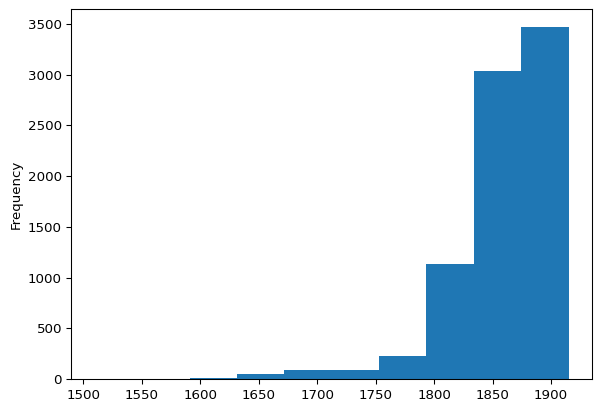

</div>

## Aller plus loin pour apprendre les regex

-   Le site [regex101](https://regex101.com/) permet de tester les expressions régulières utilisées tout en ayant une explication qui accompagne ce test

-   De même pour [ce site](https://ole.michelsen.dk/tools/regex/) qui comporte une cheat sheet en bas de la page.

-   Les jeux de [Regex Crossword](https://regexcrossword.com/) permettent d’apprendre les expressions régulières en s’amusant